# CV Coursework: Model 1: SIFT & SVM on personal dataset

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)
- **CW Owner:** Mousuf C Zaman - Student No: 180021356

# Google Colab & Env Setup

In [ ]:
!pip install facenet-pytorch
!pip install opencv-python==4.5.5.64

import os
from google.colab import drive
import numpy as np
from skimage import io
from collections import Counter
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from skimage import color, img_as_ubyte
from sklearn.cluster import MiniBatchKMeans
import random
from joblib import dump, load
from facenet_pytorch import MTCNN
from matplotlib import patches
from sklearn import svm, metrics


drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '11 - University/Colab Notebooks/Computer Vision Lab/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

%load_ext autoreload
%autoreload 2

MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
sys.path.append(MODEL_PATH)

Classifier_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code/Classifier')
sys.path.append(Classifier_PATH)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['SVM_SIFT_Personal_Dataset.ipynb.ipynb', 'Code', 'CW_Dataset', 'Models', 'CV CW Progress.gdoc', 'CV Report.docx', 'Other', 'Personal_Dataset', 'test_functions.ipynb', 'CV Demo Script.gdoc', 'SVM_SIFT_CW_Dataset.ipynb']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading


Streaming output truncated to the last 5000 lines.
Label for train image train/images/image_0574.jpeg : 2
Loading train image: train/images/image_1805.jpeg
Label for train image train/images/image_1805.jpeg : 0
Loading train image: train/images/image_0248.jpeg
Label for train image train/images/image_0248.jpeg : 0
Loading train image: train/images/image_1856.jpeg
Label for train image train/images/image_1856.jpeg : 1
Loading train image: train/images/image_1034.jpeg
Label for train image train/images/image_1034.jpeg : 0
Loading train image: train/images/image_1744.jpeg
Label for train image train/images/image_1744.jpeg : 1
Loading train image: train/images/image_2034.jpeg
Label for train image train/images/image_2034.jpeg : 1
Loading train image: train/images/image_0819.jpeg
Label for train image train/images/image_0819.jpeg : 1
Loading train image: train/images/image_1990.jpeg
Label for train image train/images/image_1990.jpeg : 1
Loading train image: train/images/image_0257.jpeg
Labe

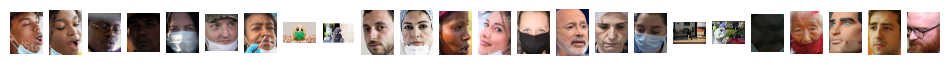

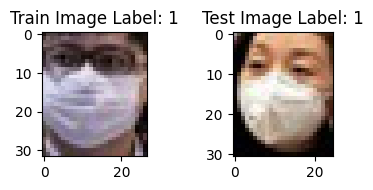

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

# Identify path to zipped dataset
zip_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTest.zip')

# Copy it to Colab
!cp '{zip_path2}' .

# Unzip it
!yes|unzip -q ownTest.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTest.zip

###################################

def load_images_and_labels(train_path, test_path, own_test_path):
    images = []
    labels = []
    own_images = []
    own_labels = []

    # Load images and labels from train folder
    train_images_path = os.path.join(train_path, 'images')
    train_labels_path = os.path.join(train_path, 'labels')
    train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
    for img_file in train_img_files:
        # Load the image and append to images list
        img_path = os.path.join(train_images_path, img_file)
        print('Loading train image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for train image', img_path, ':', label)
        else:
            print('No label found for train image:', img_path)

    # Load images and labels from test folder
    test_images_path = os.path.join(test_path, 'images')
    test_labels_path = os.path.join(test_path, 'labels')
    test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
    for img_file in test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(test_images_path, img_file)
        print('Loading test image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for test image', img_path, ':', label)
        else:
            print('No label found for test image:', img_path)

    # Load images and labels from own test folder
    own_test_images_path = os.path.join(own_test_path, 'images')
    own_test_labels_path = os.path.join(own_test_path, 'labels')
    own_test_img_files = [f for f in os.listdir(own_test_images_path) if f.endswith('.jpeg')]
    for img_file in own_test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(own_test_images_path, img_file)
        print('Loading own image:', img_path)
        image = io.imread(img_path)

        mtcnn = MTCNN(keep_all=True) 
        # Detect faces in the image
        faces_MTCNN, _ = mtcnn.detect(image, landmarks=False)

        if faces_MTCNN is not None:
            # Only use the first face detected
            face = faces_MTCNN[0]
            # Crop the image to the detected face
            face_img = image[int(face[1]):int(face[3]), int(face[0]):int(face[2])]
            own_images.append(face_img)
        else: 
        # Append the original image as is
          own_images.append(image)    

        # Load the label if it exists and append to labels list
        label_path = os.path.join(own_test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            own_labels.append(label)
            print('Label for own test image', img_path, ':', label)
        else:
            print('No label found for image:', img_path)

    # Count the number of images per label class
    label_counts = Counter(labels + own_labels)
    print('Number of images per label class:', label_counts)

    return images, own_images, labels, own_labels, label_counts


###############################################
train_path = 'train'
test_path = 'test'
own_test_path = 'ownTest'
images, X_own_test, labels, y_own_test , label_counts = load_images_and_labels(train_path, test_path, own_test_path)

# plot the images
fig, axes = plt.subplots(nrows=1, ncols=len(X_own_test), figsize=(12, 6))
for i, image in enumerate(X_own_test):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


# Tes if image has loaded correctly
# Generate 1 random index for a train image
train_idx = np.random.choice(range(len(images)), size=1, replace=False)[0]
train_filtered_image = images[train_idx]
train_filtered_label = labels[train_idx]

# Generate 1 random index for a test image
test_index = np.random.choice(range(len(images)-1), size=1, replace=False)[0]
test_filtered_image = images[test_index]
test_filtered_label = labels[test_index]

# Plot the random train image
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs[0].imshow(train_filtered_image)
axs[0].set_title('Train Image Label: ' + str(train_filtered_label))

# Plot the random test image
axs[1].imshow(test_filtered_image)
axs[1].set_title('Test Image Label: ' + str(test_filtered_label))

plt.tight_layout()
plt.show()


# Implementing feature descriptor

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[20  3  0 28  2 28 11 15]
[26 12  0 26 26  0  3 12  1  9  2 15  4  4  4  8 13  4 10 13 13  1 14 24
 24 16  6  6 11 25 16 14  2  8 13 29 19 29 12 18 21 19 16 11 20 10 20 15
 11 25 19 14 27 27 15 23 23 12  8  0 10 13 27 18 20 12 11  5 16 27 27 11
 14 27  8 22  8 12  4  1 28  3 13 20  9 14 27 16 20 21 25  4 27  8 14 13
 19 28 12 29 27  8 22  1 14 14 14 15 17 15  0  3 19 24 17 17  3 13 20 16
 10 29 17  6 25  8 17 16]


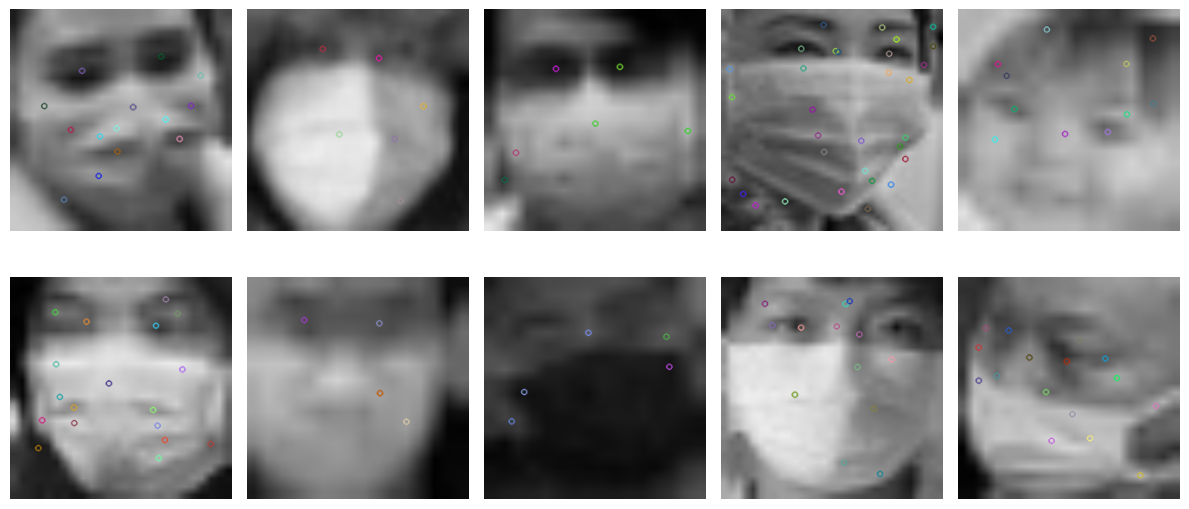

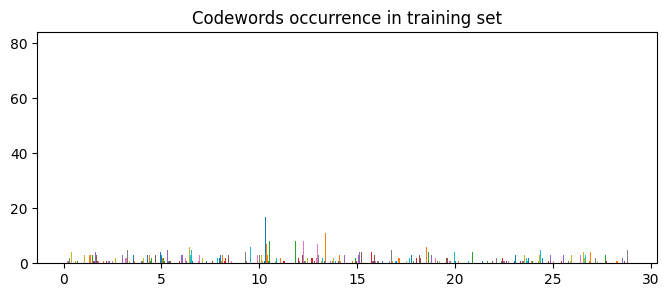

In [ ]:
# Unbalanced problem
# Split the data into training and test sets, stratified by the labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_train)):
    # Load the image and resize to target size
    img = cv2.resize(X_train[i], target_size)
    
    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))
    
    # Detect keypoints and extract descriptors with SIFT
    kp, des = sift.detectAndCompute(img_gray, None)

    # Show results for first 10 images
    if i < 10:
        row, col = i // 5, i % 5
        img_with_SIFT = cv2.drawKeypoints(img_gray, kp, img_gray)
        ax[row][col].imshow(img_with_SIFT)
        ax[row][col].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)


###################################################################
#Clustering the descriptors
from sklearn.cluster import MiniBatchKMeans
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)


###################################################################
# Testing clustering Clustering the descriptors
# Load a test image
test_img = X_train[0]
test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

# Detect keypoints and extract descriptors with SIFT
kp, des = sift.detectAndCompute(test_img_gray, None)

# Predict visual words for the descriptors using the trained KMeans model
visual_words = kmeans.predict(des)

print(visual_words)


####################################################################
# Load a test image
test_img = X_own_test[0]

# Convert the resized image to grayscale
test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

# Detect keypoints and extract descriptors with SIFT
kp, des = sift.detectAndCompute(test_img_gray, None)

# Predict visual words for the descriptors using the trained KMeans model
visual_words = kmeans.predict(des)

print(visual_words)


####################################################################
# Generate historgrams of codewords
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

# Training a classifier

In [ ]:
from train_SVM import train_rbf_SVM

##############################################################################
# TODO: Implementing a different type of SVM                                 #
##############################################################################
classifier = train_rbf_SVM(hist_array, y_train_list)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

dump(classifier, 'SVM_SIFT_Personal_Dataset.joblib') 
classifier = load('SVM_SIFT_Personal_Dataset.joblib') 

# Feature detecting on testing set and classifier implementation

In [ ]:
hist_list = []

for i in range(len(X_own_test)):
    img = img_as_ubyte(color.rgb2gray(X_own_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_own_test = [y_own_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)


##########################################################################
# Predict the classes of each test image
y_pred = classifier.predict(hist_array).tolist()

## Result

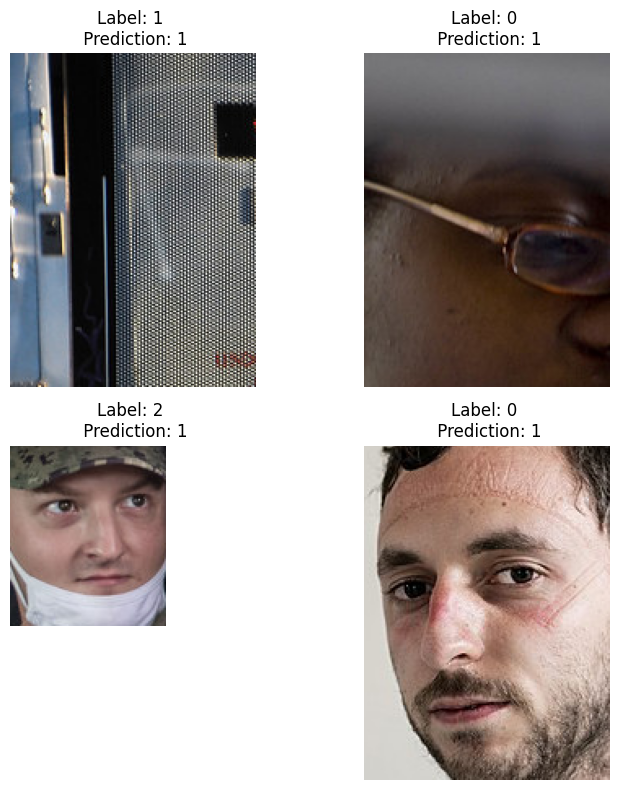

Classification report for classifier SVC(gamma=0.7):
                    precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      1.00      0.55         9
           2       0.00      0.00      0.00         7

    accuracy                           0.38        24
   macro avg       0.12      0.33      0.18        24
weighted avg       0.14      0.38      0.20        24




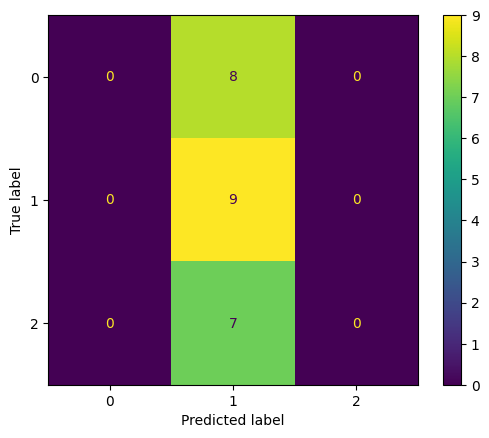

In [ ]:
import numpy as np

# Generate 4 random indices
random_indices = np.random.choice(len(X_own_test), size=4, replace=False)

# Plot the corresponding images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(X_own_test[idx])
    ax[i].set_title(f'Label: {y_own_test[idx]} \n Prediction: {y_pred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

from sklearn import metrics

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_own_test, y_pred, zero_division=0)}\n""")

metrics.ConfusionMatrixDisplay.from_predictions(y_own_test, y_pred)
plt.show()